Found 809 images belonging to 19 classes.
Found 196 images belonging to 19 classes.
Epoch 1/10
25/25 [==============================] - 368s 15s/step - loss: 2.5673 - categorical_accuracy: 0.2883 - precision: 0.3968 - recall: 0.1287 - f1_score: 0.1944 - val_loss: 4.4625 - val_categorical_accuracy: 0.1354 - val_precision: 0.1774 - val_recall: 0.1146 - val_f1_score: 0.1392
Epoch 2/10
25/25 [==============================] - 361s 14s/step - loss: 1.4440 - categorical_accuracy: 0.5251 - precision: 0.6645 - recall: 0.3900 - f1_score: 0.4915 - val_loss: 3.1701 - val_categorical_accuracy: 0.2760 - val_precision: 0.3438 - val_recall: 0.2292 - val_f1_score: 0.2750
Epoch 3/10
25/25 [==============================] - 360s 14s/step - loss: 0.7836 - categorical_accuracy: 0.7362 - precision: 0.8079 - recall: 0.6332 - f1_score: 0.7100 - val_loss: 2.1233 - val_categorical_accuracy: 0.4583 - val_precision: 0.5364 - val_recall: 0.4219 - val_f1_score: 0.4723
Epoch 4/10
25/25 [============================

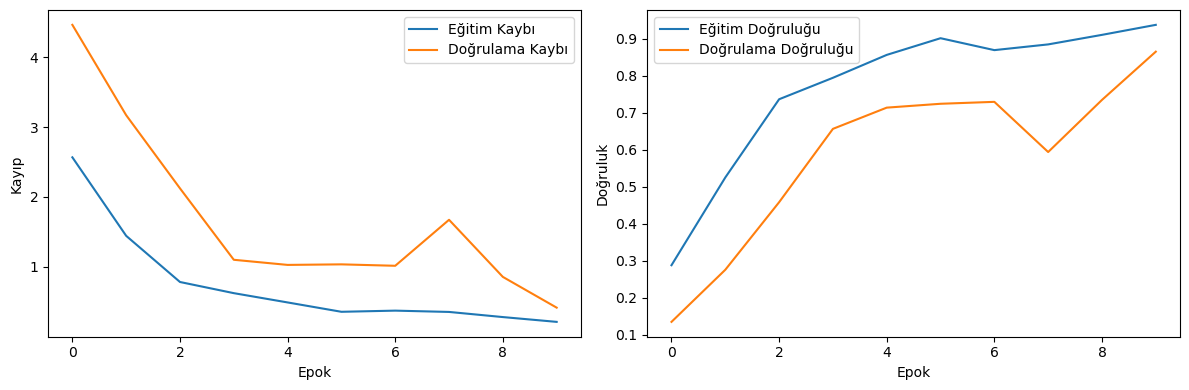

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

# Özel F1Score sınıfı tanımlama
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision_result = self.precision.result()
        recall_result = self.recall.result()
        return 2 * ((precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Veri yolu
data_dir = 'C:/Users/user/Desktop/görüntü büt/WHU-RS19'  # Eğitim ve doğrulama veri setinin yolu
image_width, image_height = 224, 224
batch_size = 32
num_classes = 19
epochs = 10

# Veri setini oluşturma (Veri artırma ile)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Doğrulama seti için ayrılan oran
    rotation_range=20,  # Rastgele döndürme açısı
    width_shift_range=0.2,  # Rastgele yatay kaydırma
    height_shift_range=0.2,  # Rastgele dikey kaydırma
    horizontal_flip=True,  # Rastgele yatay çevirme
    zoom_range=0.2  # Rastgele yakınlaştırma
)

# Eğitim seti
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Eğitim setini seçmek için
)

# Doğrulama seti
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Doğrulama setini seçmek için
)

# VGG-16 modelini kullanarak transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall(), F1Score()]
)

# Erken durdurma (early stopping) callback'ini tanımlama
early_stopping = EarlyStopping(
    monitor='val_loss',  # Doğrulama kaybını izle
    patience=3,  # 3 epok boyunca iyileşme olmazsa eğitimi durdur
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

# Modeli eğit
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]  # Erken durdurma callback'ini kullan
)

# Doğrulama veri seti üzerinde tahminler yapma
validation_loss, validation_acc, validation_prec, validation_rec, validation_f1 = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)

print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_acc}')
print(f'Validation Precision: {validation_prec}')
print(f'Validation Recall: {validation_rec}')
print(f'Validation F1 Score: {validation_f1}')


# Eğitim ve doğrulama süreçlerinin görselleştirilmesi
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_categorical_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 335ms/step
Resim 1:
Tahmin edilen sınıf: Industrial
Gerçek sınıf: Industrial
1/1 [==============================] - 0s 138ms/step
Resim 2:
Tahmin edilen sınıf: footballField
Gerçek sınıf: footballField
1/1 [==============================] - 0s 136ms/step
Resim 3:
Tahmin edilen sınıf: Mountain
Gerçek sınıf: Mountain
1/1 [==============================] - 0s 128ms/step
Resim 4:
Tahmin edilen sınıf: Industrial
Gerçek sınıf: Industrial
1/1 [==============================] - 0s 157ms/step
Resim 5:
Tahmin edilen sınıf: Industrial
Gerçek sınıf: Industrial


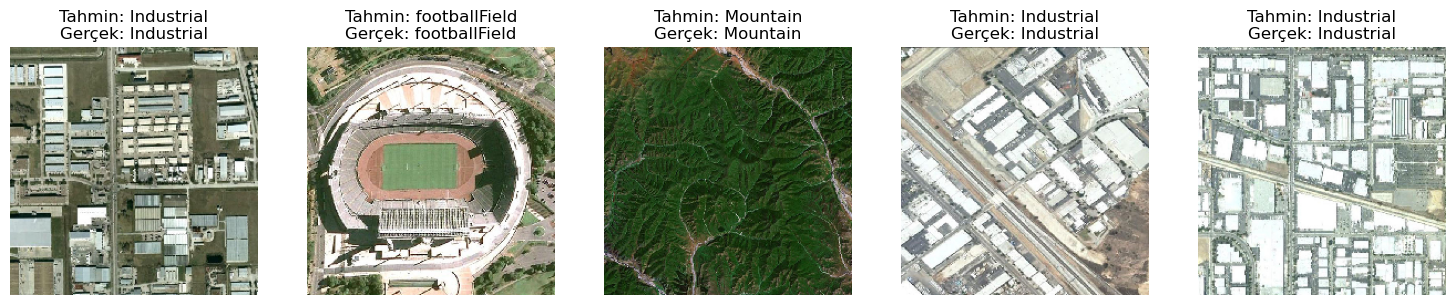

In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
test_image_paths = np.random.choice(validation_generator.filepaths, size=5, replace=False)


class_labels = list(validation_generator.class_indices.keys())
fig, axes = plt.subplots(1, 5, figsize=(15, 3))


for i, random_test_image_path in enumerate(test_image_paths):
    # Seçilen resmi yükle ve modele uygun hale getir
    img = image.load_img(random_test_image_path, target_size=(image_width, image_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Resmi normalleştir

    # Model üzerinde tahmin yap
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Gerçek sınıfı bul
    true_class = os.path.basename(os.path.dirname(random_test_image_path))  # Alt klasör adını al

    # Tahmin ve gerçek sınıfları yazdır
    print(f"Resim {i + 1}:")
    print("Tahmin edilen sınıf:", class_labels[predicted_class])
    print("Gerçek sınıf:", true_class)

    # Resmi görselleştir
    import matplotlib.pyplot as plt

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tahmin: {class_labels[predicted_class]}\nGerçek: {true_class}")

plt.tight_layout()
plt.show()

In [3]:
# Ekstra kod blok
from sklearn.metrics import confusion_matrix
import numpy as np


# Veri setinin bulunduğu dizini belirtin
dataset_dir = 'C:/Users/user/Desktop/görüntü büt/WHU-RS19' 

# Klasörleri listele
folders = os.listdir(dataset_dir)

# Her klasördeki dosyaları yazdır ve toplam resim dosyası sayısını hesapla
total_images = 0
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    print(f"Klasör: {folder}, Dosya Sayısı: {len(files)}")
    total_images += len(files)

# Toplam resim dosyası sayısını yazdır
print(f"Toplam resim dosyası sayısı: {total_images}")

# Modelin tahminleri
y_pred = model.predict(validation_generator)

# Tahmin edilen sınıflar
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek sınıflar
y_true_classes = validation_generator.classes

# Confusion matrix hesapla
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Klasör: Airport, Dosya Sayısı: 55
Klasör: Beach, Dosya Sayısı: 50
Klasör: Bridge, Dosya Sayısı: 52
Klasör: Commercial, Dosya Sayısı: 56
Klasör: Desert, Dosya Sayısı: 50
Klasör: Farmland, Dosya Sayısı: 50
Klasör: footballField, Dosya Sayısı: 50
Klasör: Forest, Dosya Sayısı: 53
Klasör: Industrial, Dosya Sayısı: 53
Klasör: Meadow, Dosya Sayısı: 61
Klasör: Mountain, Dosya Sayısı: 50
Klasör: Park, Dosya Sayısı: 50
Klasör: Parking, Dosya Sayısı: 50
Klasör: Pond, Dosya Sayısı: 54
Klasör: Port, Dosya Sayısı: 53
Klasör: railwayStation, Dosya Sayısı: 50
Klasör: Residential, Dosya Sayısı: 54
Klasör: River, Dosya Sayısı: 56
Klasör: Viaduct, Dosya Sayısı: 58
Toplam resim dosyası sayısı: 1005
7/7 [==============================] - 20s 3s/step
Confusion Matrix:
[[1 4 0 0 1 0 0 2 0 1 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 2 1 0 0 2 0 1 0 2 0 2 0 0]
 [1 0 1 0 1 1 0 2 1 0 0 0 0 1 0 0 0 1 1]
 [1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 3 1 1 1]
 [2 1 1 0 0 0 0 1 1 1 0 0 0 0 0 2 1 0 0]
 [0 1 0 2 1 0 1 1 0 1 0 0 1 0 1 0 0 1 

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 19)                9747      
                                                        